# 批量规范化

## 7.5.1 训练深层网络

- 首先，数据预处理的方式通常会对结果产生巨大影响。回想我们在应用多层感知机来预测房价的例子。使用真实数据前，我们的第一不是标准化输入特征，使其平均值为0方差为1.直观的说，这种标准化可以很好地与我们的优化器配合使用，因为它可以**将参数的量级进行统一**
- 第二，对于典型的多层感知机或卷积神经网络。当我们训练时中间层的变量可能具有更广的变化范围。批量规范化的发明者非正式地提出，这些变量分布阻碍网络的收敛。直观的说，我们可能会想，如果一个层的可变值是另一个层的100倍，这可能需要对学习率进行补偿。
- 第三，更深层的网络很复杂，容易过拟合。这意味着正则化变得更重要。

批量规范化应用于单个可选层（也可以应用所有层），其原理如下：在每次训练迭代中，我们首先规范化输入，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理。接下来，我们应用比例系数和比例偏移。这是由于这个基于*批量统计*的*标准化*，才有了批量标准化的名称。

$$
BN(X) = \gamma * \frac{x-\check{\mu}}{\check{\sigma}} + \beta
$$
在式中，$\check{\mu}$是小批量的样本均值，$\check{\sigma}$是小批量的样本标准差。应用标准化后，生成的小批量的平均值为0单位方差为1.由于单位方差(与其他一些魔法参数)是一个主观选择，因此我们通常包含*拉伸参数*$\Gamma$和*偏移参数*$\Beta$，它们的形状与$x$相同，而且是科学的参数。

## 7.5.2 批量规范化层
由于批量规范化层在完整的小批量上运行，因此我们不能像以前在引入其它层时那样忽略批量大小。我们下面讨论这两种情况：全连接层和卷积层，它们的批量规范化实现略有不同。

#### 7.5.2.1 全连接层
通常我们将批量规范层置于全连接层中的仿射变换和激活函数之间。设全连接层的输入为$x$，权重参数和偏置参数为$W$和$b$，激活函数为$\phi$,批量规范化的运算符为$BN$。那么使用批量规范化的全连接层的输出的计算详情如下：
$$
h = \phi(BN(Wx+b))
$$

#### 7.5.2.2 卷积层
对于卷积层，我们可以在卷积层之后和非线性激活函数之前应用批量规范化。当卷积有多个输出通道时，我们需要对这些通道的“每个”输出执行批量规范化，每个通道都有自己的拉伸(scale)和偏移(shift)参数，这两个参数都是标量。假设我们的小批量样本包含$m$个样本，每个通道卷积的输出具有高度$p$和宽度$q$。那么对于卷积层，我们在每个输出通道的$m·p·q$个元素上同时执行每个批量规范化。因此，在计算平均值和方差时，我们会收集所有空间位置的值然后在给定通道内应用相同的均值和方差，以便在每个空间位置对值进行规范化。

#### 7.5.2.3 预测过程中的批量规范化
批量规范化在训练模式和预测模式下的行为通常不同。首先，将训练好的模型用于预测时，我们不再需要样本均值中的噪声以及在微批次上估计每个小批次产生的样本方差了。其次，我们可能需要使用我们的模型对逐个样本进行预测。一种常用的方法是通过移动平均估算整个训练数据集的样本均值和方差，并在预测时使用它们确定得到的输出。

In [1]:
import torch
from d2l import torch as d2l
torch.cuda.device_count()

1

从零实现

In [2]:
import torch
from torch import nn
from d2l import torch as d2l
torch.cuda.device_count()

1

In [3]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
  # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
  if not torch.is_grad_enabled():
    # 如果是预测模式下，直接使用传入的移动平均所得的均值和方差
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
  else:
    assert len(X.shape) in (2, 4)
    if len(X.shape) == 2:
      # 使用全连接层的情况，计算特征维上的均值和方差
      mean = X.mean(dim=0)
      var = ((X - mean) ** 2).mean(dim=0)
    else:
      # 使用二维卷积层的情况，计算通道维上(axis=1)的均值和方差
      # 这里我们需要保持x的形状做广播操作
      mean = X.mean(dim=(0, 2, 3), keepdim=True)
      var = ((X - mean) ** 2).mean(dim = (0, 2, 3), keepdim=True)
    # 训练模式下，用当前的均值和方差做标准化
    X_hat = (X - mean) / torch.sqrt(var + eps)
    # 更新移动平均值和方差
    moving_mean = momentum * moving_mean + (1 - momentum) * mean
    moving_var = momentum * moving_var + (1 - momentum) * var
  Y = gamma * X_hat + beta  # 缩放和移位
  return Y, moving_mean.data, moving_var.data

创建一个正确的`BatchNorm`图层

In [4]:
class BatchNorm(nn.Module):
  def __init__(self, num_features, num_dims):
    super().__init__()
    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.zeros(shape)

  def forward(self, X):
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)
    Y, self.moving_mean, self.moving_var = batch_norm(
        X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9)
    return Y


应用`BatchNorm`于LeNet模型

In [5]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(16*4*4, 120),
    BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2),
    nn.Sigmoid(), nn.Linear(84, 10)
)

在`Fashion-MNIST`数据集上训练网络

loss 0.246, train acc 0.910, test acc 0.823
30120.9 examples/sec on cuda:0


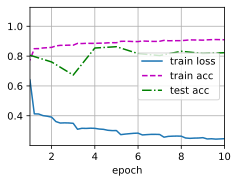

In [6]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

拉伸参数`gamma`及偏移参数`beta`

In [7]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([1.3501, 1.7777, 2.1544, 2.3524, 1.6179, 2.0925], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>),
 tensor([-1.0071,  0.0461,  0.7835, -0.1928, -0.5003, -2.1845], device='cuda:0',
        grad_fn=<ReshapeAliasBackward0>))

简洁实现

In [8]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16),
    nn.Sigmoid(), nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(), nn.Linear(16*4*4, 120),
    nn.BatchNorm2d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm2d(84),
    nn.Sigmoid(), nn.Linear(84, 10)
)